In [2]:
from gc import callbacks
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import streamlit as st
from keras.src.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GRU

In [3]:
# dhg imp opc tra
df = pd.read_csv('data/fact_trade_history.csv')

In [4]:
DHG = df[(df.ticker == 'DHG')]
OPC = df[(df.ticker == 'OPC')]
IMP = df[(df.ticker == 'IMP')]
TRA = df[(df.ticker == 'TRA')]

In [5]:
DHG.time = pd.to_datetime(DHG.time)
DHG.set_index('time', inplace=True)
OPC.time = pd.to_datetime(OPC.time)
OPC.set_index('time', inplace=True)
IMP.time = pd.to_datetime(IMP.time)
IMP.set_index('time', inplace=True)
TRA.time = pd.to_datetime(TRA.time)
TRA.set_index('time', inplace=True)

C:\Users\hoang\AppData\Local\Temp\ipykernel_12184\325783386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DHG.time = pd.to_datetime(DHG.time)
C:\Users\hoang\AppData\Local\Temp\ipykernel_12184\325783386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OPC.time = pd.to_datetime(OPC.time)
C:\Users\hoang\AppData\Local\Temp\ipykernel_12184\325783386.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [ ]:
# DHG['percent_change'] = DHG['close'].pct_change() * 100  
# DHG = DHG.dropna()  
# OPC['percent_change'] = OPC['close'].pct_change() * 100  
# OPC = OPC.dropna()  
# IMP['percent_change'] = IMP['close'].pct_change() * 100  
# IMP = IMP.dropna()
# TRA['percent_change'] = TRA['close'].pct_change() * 100  
# TRA = TRA.dropna() 

In [6]:
DHG = DHG.sort_values(by='time')
OPC = OPC.sort_values(by='time')
IMP = IMP.sort_values(by='time')
TRA = TRA.sort_values(by='time')

In [7]:
DHG.to_csv('data/DHG.csv')
OPC.to_csv('data/OPC.csv')
IMP.to_csv('data/IMP.csv')
TRA.to_csv('data/TRA.csv')

Training model for DHG


In [57]:
del model  # Xóa model cũ
tf.keras.backend.clear_session()  # Giải phóng bộ nhớ

df = pd.read_csv('data/DHG.csv', index_col=0, parse_dates=True)
df.drop('ticker',axis=1,inplace=True)

# Chuẩn hóa dữ liệu nhưng giữ nguyên index
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = df.copy().astype(float)  # Ép kiểu dữ liệu về float64
scaler_close = MinMaxScaler()  # Tạo scaler riêng cho cột close
df['close_scaled'] = scaler_close.fit_transform(df[['close']])  # Chỉ fit_transform cột close

def create_sequences(data, lookback=30):
    X, y = [], []
    index_list = data.index.to_list()  # Lấy danh sách thời gian (index)

    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i + lookback].values)  # Lấy 50 điểm làm đầu vào
        y.append(data.iloc[i + lookback, 0])  # Giá trị `close_scaled` tiếp theo làm đầu ra

    return np.array(X), np.array(y), index_list[lookback:]  # Trả về index tương ứng

lookback = 30
# Giả sử bạn đã tạo sequences
X, y, index_list = create_sequences(df[['close_scaled']], lookback=30)

index_list = df_scaled.index[lookback:]  # Lấy index sau khi tạo sequences

# Tạo mask dạng Boolean
train_mask = index_list < '2023-01-01'
val_mask = (index_list >= '2023-01-01') & (index_list < '2024-09-01')
test_mask = index_list >= '2024-09-01'

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Khởi tạo mô hình
model = Sequential([
    GRU(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.3),
    Dense(25),
    Dense(1)
])

# Compile mô hình
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mae'])

# Hiển thị kiến trúc mô hình
model.summary()

D:\Projects\stock_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 100)        │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        22,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,001 (214.85 KB)

 Trainable params: 55,001 (214.85 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, verbose=2,callbacks=[early_stopping])


Epoch 1/100
70/70 - 4s - 57ms/step - loss: 0.0068 - mae: 0.0566 - val_loss: 0.0014 - val_mae: 0.0308
Epoch 2/100
70/70 - 1s - 14ms/step - loss: 0.0024 - mae: 0.0358 - val_loss: 5.8022e-04 - val_mae: 0.0150
Epoch 3/100
70/70 - 1s - 14ms/step - loss: 0.0019 - mae: 0.0311 - val_loss: 5.7013e-04 - val_mae: 0.0163
Epoch 4/100
70/70 - 1s - 14ms/step - loss: 0.0016 - mae: 0.0290 - val_loss: 5.9968e-04 - val_mae: 0.0184
Epoch 5/100
70/70 - 1s - 14ms/step - loss: 0.0014 - mae: 0.0276 - val_loss: 9.8215e-04 - val_mae: 0.0247
Epoch 6/100
70/70 - 1s - 14ms/step - loss: 0.0011 - mae: 0.0241 - val_loss: 5.1420e-04 - val_mae: 0.0162
Epoch 7/100
70/70 - 1s - 14ms/step - loss: 0.0011 - mae: 0.0246 - val_loss: 4.8900e-04 - val_mae: 0.0139
Epoch 8/100
70/70 - 1s - 14ms/step - loss: 8.9143e-04 - mae: 0.0222 - val_loss: 8.3342e-04 - val_mae: 0.0221
Epoch 9/100
70/70 - 1s - 14ms/step - loss: 8.4157e-04 - mae: 0.0222 - val_loss: 6.1594e-04 - val_mae: 0.0172
Epoch 10/100
70/70 - 1s - 14ms/step - loss: 8.3480e

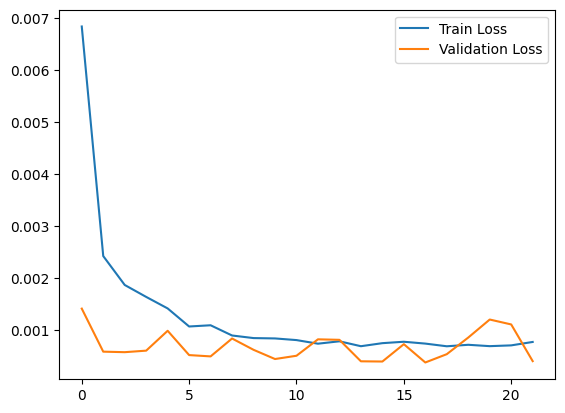

Train Loss: 0.0008
Validation Loss: 0.0004
Test Loss: 0.0001


In [61]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.legend()
plt.show()

# Lấy loss cuối cùng từ history của mô hình đã train
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Nếu có tập test, dự đoán và tính test loss
test_loss = model.evaluate(X_test, y_test, verbose=0)
if isinstance(test_loss, list):
    test_loss = test_loss[0]
# In kết quả
print(f"Train Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


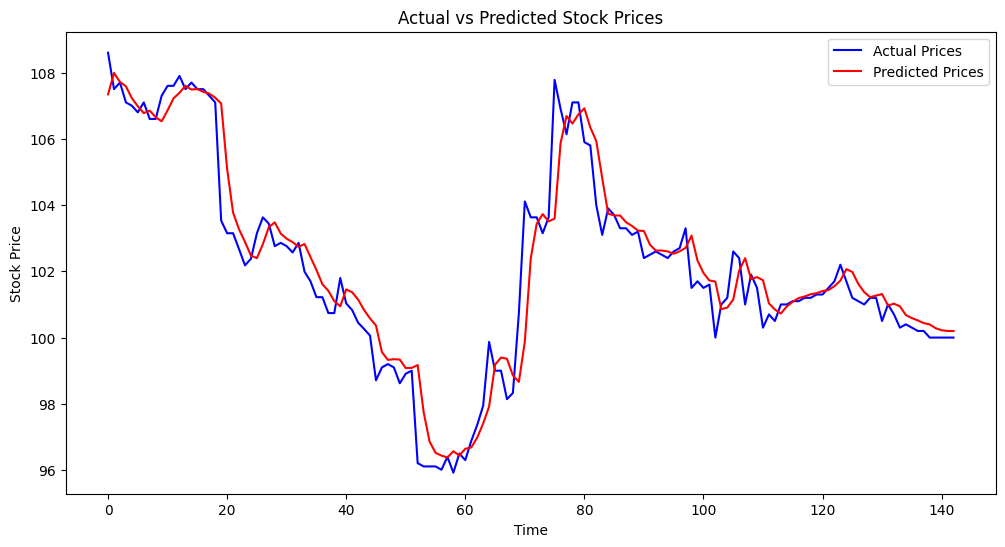

In [62]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Chuyển giá trị dự đoán và thực tế về thang đo ban đầu
y_pred_rescaled = scaler_close.inverse_transform(y_pred.reshape(-1, 1))  # Đảm bảo đúng shape
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))  # Chuyển y_test về dạng (n,1) trước khi inverse_transform

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="red")
plt.legend()
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

MAE: 0.5796
MSE: 0.8415
RMSE: 0.9173
R² Score: 0.9091


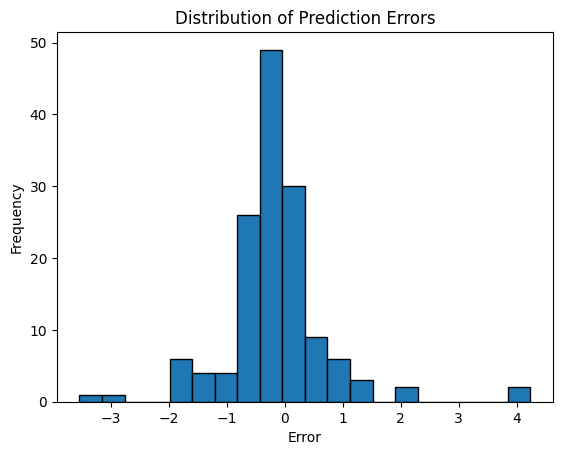

In [63]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

errors = y_test_rescaled - y_pred_rescaled
plt.hist(errors, bins=20, edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

# MAE: 0.9205
# MSE: 1.5342
# RMSE: 1.2386
# R² Score: 0.8344

# MAE: 0.6520
# MSE: 0.9697
# RMSE: 0.9848
# R² Score: 0.8953
# Train Loss: 0.0008
# Validation Loss: 0.0004
# Test Loss: 0.0001

In [26]:
model.save("GRU_DHG_model.keras")

Training model for IMP

In [69]:
# del model  # Giải phóng bộ nhớ
# tf.keras.backend.clear_session()  # Giải phóng bộ nhớ

df = pd.read_csv('data/IMP.csv', index_col=0, parse_dates=True)
df.drop('ticker',axis=1,inplace=True)

# Chuẩn hóa dữ liệu nhưng giữ nguyên index
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = df.copy().astype(float)  # Ép kiểu dữ liệu về float64
scaler_close = MinMaxScaler()  # Tạo scaler riêng cho cột close
df['close_scaled'] = scaler_close.fit_transform(df[['close']])  # Chỉ fit_transform cột 


def create_sequences(data, lookback=30):
    X, y = [], []
    index_list = data.index.to_list()  # Lấy danh sách thời gian (index)

    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i + lookback].values)  # Lấy 50 điểm làm đầu vào
        y.append(data.iloc[i + lookback, 0])  # Giá trị `close_scaled` tiếp theo làm đầu ra

    return np.array(X), np.array(y), index_list[lookback:]  # Trả về index tương ứng

lookback = 30
# Giả sử bạn đã tạo sequences
X, y, index_list = create_sequences(df[['close_scaled']], lookback=30)

index_list = df_scaled.index[lookback:]  # Lấy index sau khi tạo sequences

# Tạo mask dạng Boolean
train_mask = index_list < '2023-01-01'
val_mask = (index_list >= '2023-01-01') & (index_list < '2024-09-01')
test_mask = index_list >= '2024-09-01'

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# Khởi tạo mô hình
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])


# Compile mô hình
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mae'])


# Hiển thị kiến trúc mô hình
model.summary()

D:\Projects\stock_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 30, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100, batch_size=16, verbose=2,callbacks=[early_stop])

Epoch 1/100
139/139 - 5s - 38ms/step - loss: 0.0025 - mae: 0.0310 - val_loss: 7.2353e-04 - val_mae: 0.0230
Epoch 2/100
139/139 - 1s - 9ms/step - loss: 6.6696e-04 - mae: 0.0179 - val_loss: 3.5271e-04 - val_mae: 0.0114
Epoch 3/100
139/139 - 1s - 9ms/step - loss: 4.8520e-04 - mae: 0.0149 - val_loss: 3.5148e-04 - val_mae: 0.0132
Epoch 4/100
139/139 - 1s - 11ms/step - loss: 3.8418e-04 - mae: 0.0136 - val_loss: 4.4828e-04 - val_mae: 0.0146
Epoch 5/100
139/139 - 1s - 10ms/step - loss: 3.2620e-04 - mae: 0.0124 - val_loss: 3.2169e-04 - val_mae: 0.0113
Epoch 6/100
139/139 - 1s - 9ms/step - loss: 3.4740e-04 - mae: 0.0134 - val_loss: 3.0996e-04 - val_mae: 0.0114
Epoch 7/100
139/139 - 1s - 9ms/step - loss: 3.1366e-04 - mae: 0.0126 - val_loss: 2.7118e-04 - val_mae: 0.0107
Epoch 8/100
139/139 - 2s - 11ms/step - loss: 3.0356e-04 - mae: 0.0123 - val_loss: 2.8555e-04 - val_mae: 0.0105
Epoch 9/100
139/139 - 2s - 11ms/step - loss: 2.7143e-04 - mae: 0.0115 - val_loss: 2.5071e-04 - val_mae: 0.0096
Epoch 10/

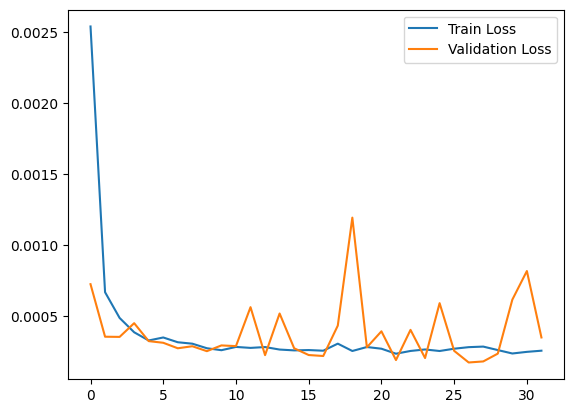

Train Loss: 0.0003
Validation Loss: 0.0003
Test Loss: 0.0006


In [71]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Lấy loss cuối cùng từ history của mô hình đã train
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Nếu có tập test, dự đoán và tính test loss
test_loss = model.evaluate(X_test, y_test, verbose=0)
if isinstance(test_loss, list):
    test_loss = test_loss[0]
# In kết quả
print(f"Train Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


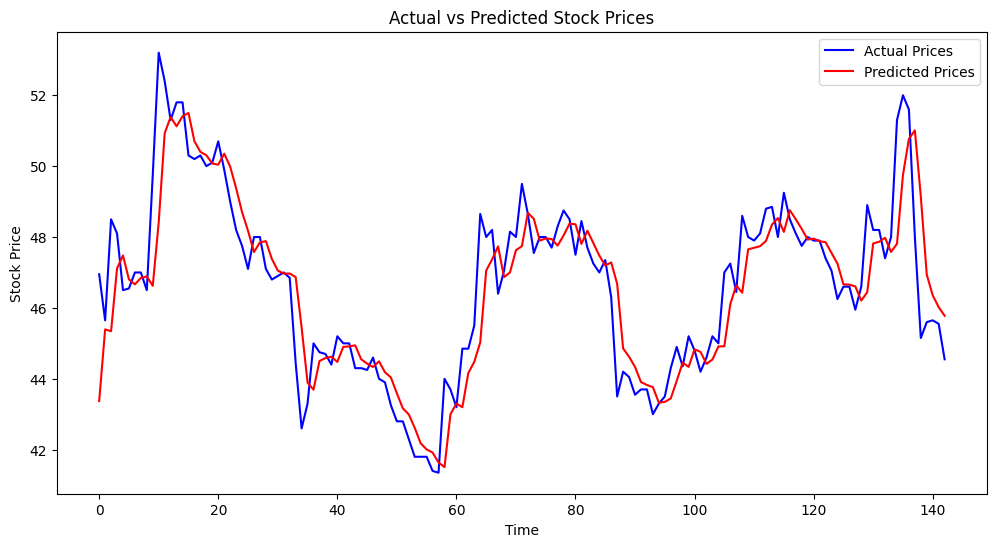

In [72]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Chuyển giá trị dự đoán và thực tế về thang đo ban đầu
y_pred_rescaled = scaler_close.inverse_transform(y_pred.reshape(-1, 1))  # Đảm bảo đúng shape
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))  # Chuyển y_test về dạng (n,1) trước khi inverse_transform

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="red")
plt.legend()
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

MAE: 0.8107
MSE: 1.4755
RMSE: 1.2147
R² Score: 0.7623


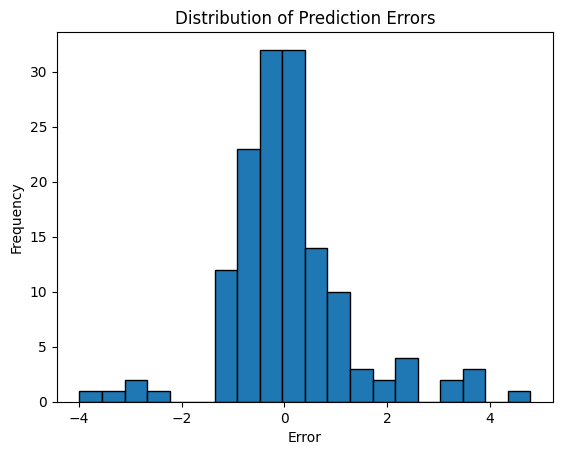

In [73]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

errors = y_test_rescaled - y_pred_rescaled
plt.hist(errors, bins=20, edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

# MAE: 0.8850
# MSE: 1.7512
# RMSE: 1.3233
# R² Score: 0.7179

# MAE: 0.9206
# MSE: 1.6380
# RMSE: 1.2798
# R² Score: 0.7362

# MAE: 1.0615
# MSE: 2.1146
# RMSE: 1.4542
# R² Score: 0.6594


# MAE: 0.8103
# MSE: 1.4342
# RMSE: 1.1976
# R² Score: 0.7690

# MAE: 0.5796
# MSE: 0.8415
# RMSE: 0.9173
# R² Score: 0.9091

# MAE: 0.8107
# MSE: 1.4755
# RMSE: 1.2147
# R² Score: 0.7623

# Train Loss: 0.0003
# Validation Loss: 0.0003
# Test Loss: 0.0006

In [74]:
model.save("GRU_IMP_model.keras")

Loading Pre-trained Model

In [110]:
# del model  # Giải phóng bộ nhớ
# tf.keras.backend.clear_session()  # Giải phóng bộ nhớ
df = pd.read_csv('data/TRA.csv', index_col=0, parse_dates=True)
df.drop('ticker',axis=1,inplace=True)

# Chuẩn hóa dữ liệu nhưng giữ nguyên index
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = df.copy().astype(float)  # Ép kiểu dữ liệu về float64
scaler_close = MinMaxScaler()  # Tạo scaler riêng cho cột close
df['close_scaled'] = scaler_close.fit_transform(df[['close']])  # Chỉ fit_transform cột 


def create_sequences(data, lookback=30):
    X, y = [], []
    index_list = data.index.to_list()  # Lấy danh sách thời gian (index)

    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i + lookback].values)  # Lấy 50 điểm làm đầu vào
        y.append(data.iloc[i + lookback, 0])  # Giá trị `close_scaled` tiếp theo làm đầu ra

    return np.array(X), np.array(y), index_list[lookback:]  # Trả về index tương ứng

lookback = 30
# Giả sử bạn đã tạo sequences
X, y, index_list = create_sequences(df[['close_scaled']], lookback=30)

index_list = df_scaled.index[lookback:]  # Lấy index sau khi tạo sequences

# Tạo mask dạng Boolean
train_mask = index_list < '2023-01-01'
val_mask = (index_list >= '2023-01-01') & (index_list < '2024-09-01')
test_mask = index_list >= '2024-09-01'

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# Khởi tạo mô hình
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Dự đoán giá trị `close`
])

# Compile mô hình
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Hiển thị kiến trúc mô hình
model.summary()


D:\Projects\stock_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                    │ (None, 30, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100, batch_size=16, verbose=2,callbacks=[early_stopping])

Epoch 1/100
139/139 - 5s - 33ms/step - loss: 0.0285 - mae: 0.1170 - val_loss: 0.0014 - val_mae: 0.0331
Epoch 2/100
139/139 - 1s - 10ms/step - loss: 0.0042 - mae: 0.0496 - val_loss: 3.7744e-04 - val_mae: 0.0138
Epoch 3/100
139/139 - 1s - 10ms/step - loss: 0.0032 - mae: 0.0392 - val_loss: 5.9963e-04 - val_mae: 0.0192
Epoch 4/100
139/139 - 1s - 9ms/step - loss: 0.0031 - mae: 0.0386 - val_loss: 4.0386e-04 - val_mae: 0.0145
Epoch 5/100
139/139 - 1s - 10ms/step - loss: 0.0024 - mae: 0.0347 - val_loss: 3.6257e-04 - val_mae: 0.0135
Epoch 6/100
139/139 - 1s - 10ms/step - loss: 0.0025 - mae: 0.0343 - val_loss: 3.8617e-04 - val_mae: 0.0142
Epoch 7/100
139/139 - 2s - 11ms/step - loss: 0.0023 - mae: 0.0335 - val_loss: 3.5466e-04 - val_mae: 0.0133
Epoch 8/100
139/139 - 2s - 11ms/step - loss: 0.0021 - mae: 0.0324 - val_loss: 3.8694e-04 - val_mae: 0.0143
Epoch 9/100
139/139 - 2s - 11ms/step - loss: 0.0021 - mae: 0.0318 - val_loss: 3.5195e-04 - val_mae: 0.0133
Epoch 10/100
139/139 - 2s - 11ms/step - lo

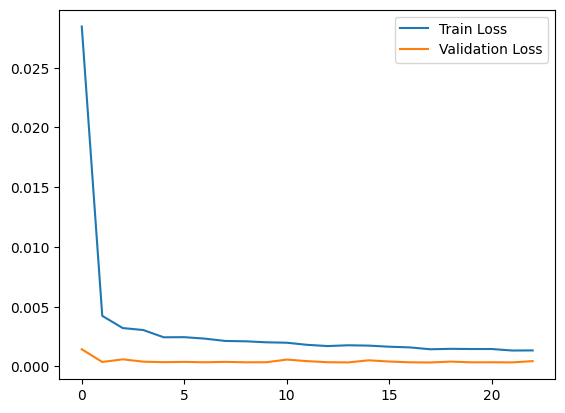

Train Loss: 0.0013
Validation Loss: 0.0004
Test Loss: 0.0001


In [112]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Lấy loss cuối cùng từ history của mô hình đã train
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Nếu có tập test, dự đoán và tính test loss
test_loss = model.evaluate(X_test, y_test, verbose=0)
if isinstance(test_loss, list):
    test_loss = test_loss[0]
# In kết quả
print(f"Train Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


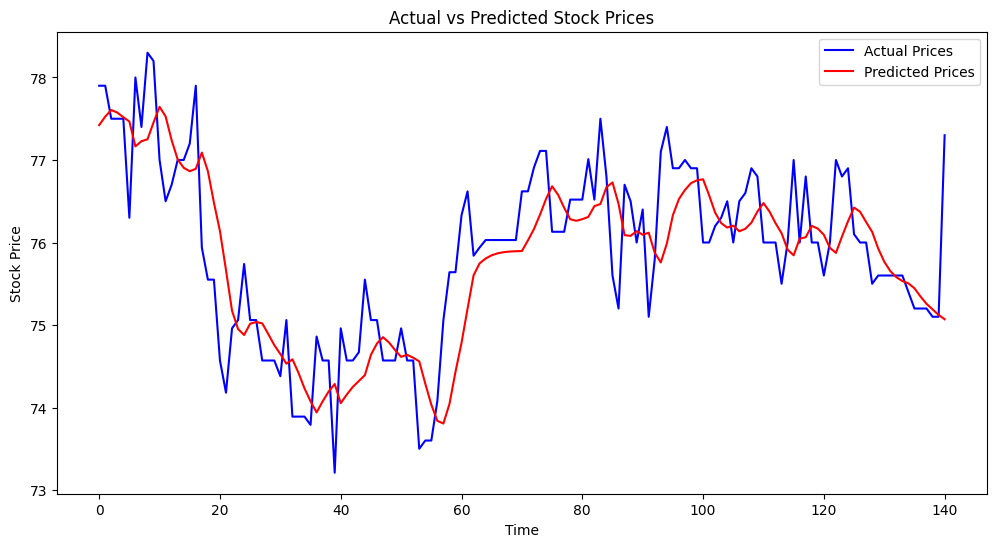

In [113]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Chuyển giá trị dự đoán và thực tế về thang đo ban đầu
y_pred_rescaled = scaler_close.inverse_transform(y_pred.reshape(-1, 1))  # Đảm bảo đúng shape
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))  # Chuyển y_test về dạng (n,1) trước khi inverse_transform

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="red")
plt.legend()
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

MAE: 0.5079
MSE: 0.4438
RMSE: 0.6662
R² Score: 0.6187


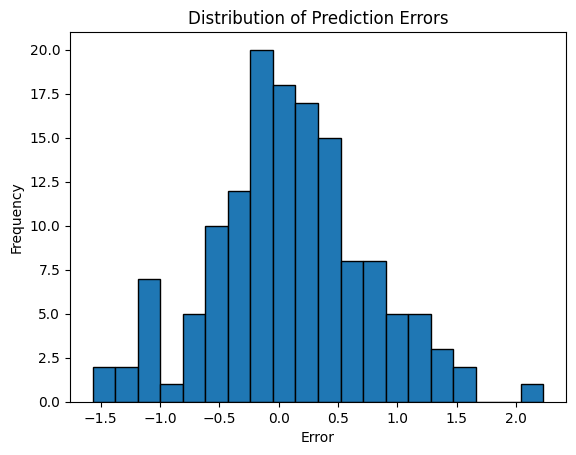

In [114]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

errors = y_test_rescaled - y_pred_rescaled
plt.hist(errors, bins=20, edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


# MAE: 0.5174
# MSE: 0.4545
# RMSE: 0.6742
# R² Score: 0.6094

# MAE: 0.5433
# MSE: 0.4855
# RMSE: 0.6968
# R² Score: 0.5829

# MAE: 0.5299
# MSE: 0.4671
# RMSE: 0.6835
# R² Score: 0.5986

# MAE: 0.5223
# MSE: 0.4627
# RMSE: 0.6802
# R² Score: 0.6025

# MAE: 0.5079
# MSE: 0.4438
# RMSE: 0.6662
# R² Score: 0.6187

In [115]:
model.save("GRU_TRA_model.keras")

In [152]:
# del model  # Xóa model cũ
# tf.keras.backend.clear_session()  # Giải phóng bộ nhớ

df = pd.read_csv('data/pharma.csv', index_col=0, parse_dates=True)

# Chuẩn hóa dữ liệu nhưng giữ nguyên index
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = df.copy().astype(float)  # Ép kiểu dữ liệu về float64
scaler_close = MinMaxScaler()  # Tạo scaler riêng cho cột close
df['close_scaled'] = scaler_close.fit_transform(df[['close']])  # Chỉ fit_transform cột close

def create_sequences(data, lookback=30):
    X, y = [], []
    index_list = data.index.to_list()  # Lấy danh sách thời gian (index)

    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i + lookback].values)  # Lấy 50 điểm làm đầu vào
        y.append(data.iloc[i + lookback, 0])  # Giá trị `close_scaled` tiếp theo làm đầu ra

    return np.array(X), np.array(y), index_list[lookback:]  # Trả về index tương ứng

lookback = 30
# Giả sử bạn đã tạo sequences
X, y, index_list = create_sequences(df[['close_scaled']], lookback=30)

index_list = df_scaled.index[lookback:]  # Lấy index sau khi tạo sequences

# Tạo mask dạng Boolean
train_mask = index_list < '2023-01-01'
val_mask = (index_list >= '2023-01-01') & (index_list < '2024-09-01')
test_mask = index_list >= '2024-09-01'

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Khởi tạo mô hình
model = Sequential([
    GRU(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile mô hình
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mae'])

# Hiển thị kiến trúc mô hình
model.summary()

D:\Projects\stock_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                    │ (None, 30, 100)        │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 50)             │        22,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,001 (214.85 KB)

 Trainable params: 55,001 (214.85 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100, batch_size=16, verbose=2,callbacks=[early_stopping])

Epoch 1/100
139/139 - 7s - 50ms/step - loss: 0.0048 - mae: 0.0377 - val_loss: 6.3454e-04 - val_mae: 0.0146
Epoch 2/100
139/139 - 2s - 14ms/step - loss: 7.9185e-04 - mae: 0.0200 - val_loss: 7.3274e-04 - val_mae: 0.0157
Epoch 3/100
139/139 - 2s - 14ms/step - loss: 5.9726e-04 - mae: 0.0174 - val_loss: 6.2209e-04 - val_mae: 0.0140
Epoch 4/100
139/139 - 2s - 14ms/step - loss: 5.5054e-04 - mae: 0.0163 - val_loss: 0.0019 - val_mae: 0.0357
Epoch 5/100
139/139 - 2s - 14ms/step - loss: 5.0702e-04 - mae: 0.0162 - val_loss: 0.0013 - val_mae: 0.0275
Epoch 6/100
139/139 - 2s - 13ms/step - loss: 4.2992e-04 - mae: 0.0144 - val_loss: 6.7151e-04 - val_mae: 0.0134
Epoch 7/100
139/139 - 2s - 12ms/step - loss: 3.8251e-04 - mae: 0.0141 - val_loss: 6.0979e-04 - val_mae: 0.0122
Epoch 8/100
139/139 - 2s - 12ms/step - loss: 3.8433e-04 - mae: 0.0142 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 9/100
139/139 - 2s - 13ms/step - loss: 2.8069e-04 - mae: 0.0120 - val_loss: 6.1448e-04 - val_mae: 0.0119
Epoch 10/100
139/

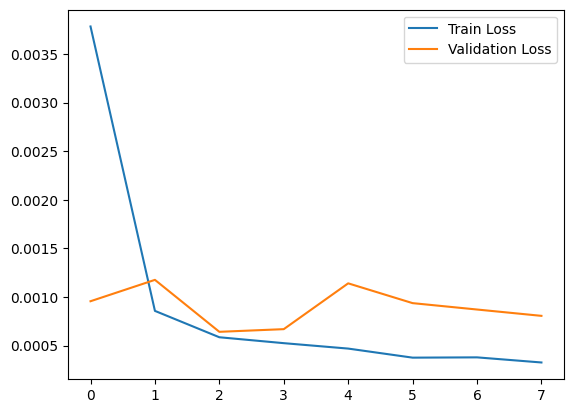

Train Loss: 0.0003
Validation Loss: 0.0008
Test Loss: 0.0016


In [149]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Lấy loss cuối cùng từ history của mô hình đã train
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Nếu có tập test, dự đoán và tính test loss
test_loss = model.evaluate(X_test, y_test, verbose=0)
if isinstance(test_loss, list):
    test_loss = test_loss[0]
# In kết quả
print(f"Train Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


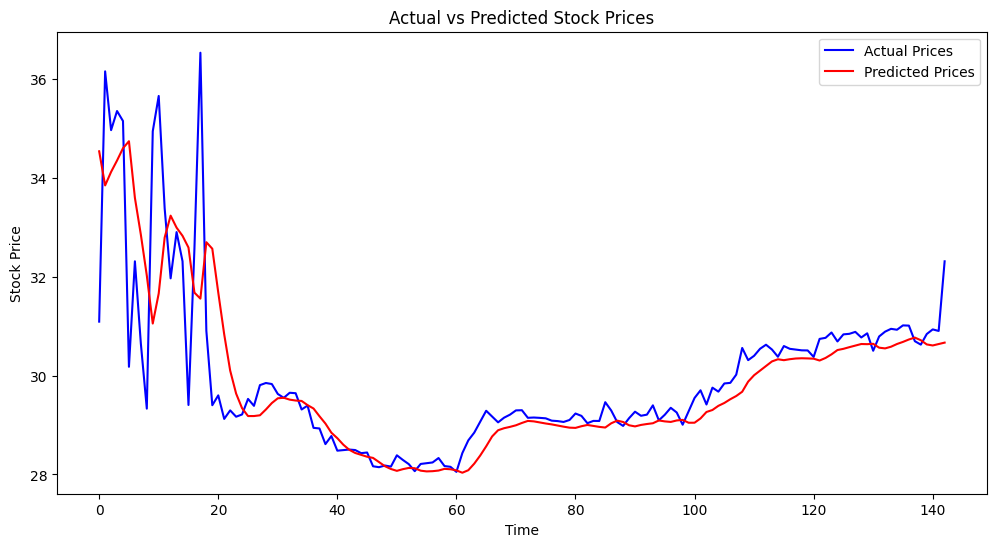

In [150]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Chuyển giá trị dự đoán và thực tế về thang đo ban đầu
y_pred_rescaled = scaler_close.inverse_transform(y_pred.reshape(-1, 1))  # Đảm bảo đúng shape
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))  # Chuyển y_test về dạng (n,1) trước khi inverse_transform

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="red")
plt.legend()
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

MAE: 0.5455
MSE: 1.0993
RMSE: 1.0485
R² Score: 0.5966


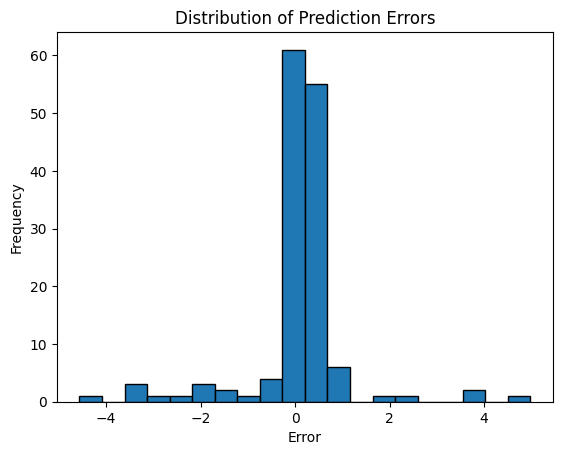

In [151]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

errors = y_test_rescaled - y_pred_rescaled
plt.hist(errors, bins=20, edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

# MAE: 0.5071
# MSE: 1.1270
# RMSE: 1.0616
# R² Score: 0.5865

# MAE: 0.5003
# MSE: 1.0913
# RMSE: 1.0447
# R² Score: 0.5996


In [142]:
model.save("GRU_pharma_model.keras")